# Run Random Forest

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import missingno as msno # For visualizing missing values

# My functions
import sys
sys.path.insert(0, "../../src")
from run_mp import *
from nfi_wrangling import *

## Load NFI Dataset

In [2]:
# Load NFI Data
nfi_final_data = pd.read_csv(
    "../00_process_nfi_data/20231123-191200_nfi_dataset_for_analysis copy.csv",
    index_col=[0],
)

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_13235/1098258182.py:2: DtypeWarning: Columns (57,64,67,79,80,81,94,95,96,97,112,113,118,119,121,125,131,133,163) have mixed types. Specify dtype option on import or set low_memory=False.
  nfi_final_data = pd.read_csv(


## Check for documented / undocumented variables

In [3]:
# Original NFI Variables
nfi_org = pd.read_excel(
    "ifna_predictor_database.xlsx",
    sheet_name="NFI Original Variables",
)[["var", "type", "level", "remove"]]

# NFI Derivative Variables
nfi_derivatives = (
    pd.read_excel(
        "20231124_ifna_predictor_database.xlsx",
        sheet_name="NFI Derivatives",
    )
    .reset_index()[["var", "type", "level", "remove"]]
    .dropna(subset=["type"])
)

# Add suffixes _1 and _2 to the original variables
suffix_1 = nfi_org.copy()
suffix_2 = nfi_org.copy()

suffix_1["var"] = suffix_1["var"].apply(lambda x: x + "_1")
suffix_2["var"] = suffix_2["var"].apply(lambda x: x + "_2")

# Concatenate them
vars_described_in_sheet = pd.concat([nfi_org, suffix_1, suffix_2, nfi_derivatives])
# vars_described_in_sheet

# Extract variables that are in the final wrangled nfi dataset
final_vars = nfi_final_data.columns.to_frame(index=False, name="var").sort_values("var")

# Remove all variables that can be found in the excel file:
mask = final_vars["var"].isin(vars_described_in_sheet["var"])
not_described_vars = final_vars[~mask]

# Print output
print("Variables that are not registered in the excel (should show empty dataframe):")
display(not_described_vars)

# Check if variables are described in the excel file that are not in the final wrangled nfi dataset
# Extract all derivatives
all_ders = nfi_derivatives["var"]

# Find entries in var that are in all_ders but not in final_vars
mask = nfi_derivatives["var"].isin(final_vars["var"])
documented_but_not_in_final_df = nfi_derivatives[~mask]

# Print the output
print(
    "Variables that are documented in the excel but not in the final wrangled nfi dataframe (should show only variables with level 'grouping'):"
)
display(documented_but_not_in_final_df)

Variables that are not registered in the excel (should show empty dataframe):


,var


Variables that are documented in the excel but not in the final wrangled nfi dataframe (should show only variables with level 'grouping'):


,var,type,level,remove
53,n_plots,num,grouping,NaN
54,n_ini,num,grouping,NaN
55,n_sur,num,grouping,NaN
56,n_fin,num,grouping,NaN
57,n_rec,num,grouping,NaN
58,ba_at_v1_of_alive_trees,num,grouping,NaN
59,ba_at_v2_of_alive_trees,num,grouping,NaN
60,ba_at_v1_of_survivors,num,grouping,NaN
61,ba_at_v2_of_survivors,num,grouping,NaN
62,ba_at_v1_of_dead,num,grouping,NaN


## Encode variables as specified in the excel file

In [4]:
# CATEGORICAL VARIABLES
# Encode variables that are cat in column type in vars_described_in_sheet as categorical in nfi_final_data
# Filter vars_described_in_sheet to hold only variables contained in nfi_final_data
mask = vars_described_in_sheet["var"].isin(nfi_final_data.columns)

# Further filter to hold only categorical variables
cat_vars = vars_described_in_sheet.loc[
    (vars_described_in_sheet["type"] == "cat") & mask, "var"
].to_list()

# Encode them as categorical in nfi_final_data
nfi_final_data[cat_vars] = nfi_final_data[cat_vars].astype("category")

# DATE VARIABLES (by hand, routine caused errors...)
nfi_final_data["dateeco"] = nfi_final_data["dateeco"].astype("datetime64[ns]")
nfi_final_data["datemort"] = nfi_final_data["datemort"].astype("datetime64[ns]")

## Calculate plot-level mortality

In [5]:
# Calculate growth and mortality at the plot-level
run_cell = False

if run_cell:
    # ⚠️  This takes about 30 minutes to run, so loading the data from the feather file instead
    #     Plus, for some reason, after running this cell, the notebook slows down massively.

    grouped = nfi_final_data.groupby("idp", as_index=False)
    df_list = [group for name, group in grouped]

    # df_list = df_list[:100] # For debug, reduce number to 100 sites only

    out = run_mp(
        calculate_growth_mortality,
        df_list,
        combine_func=pd.concat,
        progress_bar=True,
        num_cores=10,
    )

    out.to_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

out = pd.read_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")
# out.shape
# out.head(100)

## Merge location-data back in

In [6]:
# Get subset
nfi_subset = nfi_final_data.copy()

# TODO: This is just a quick fix until correction has been made on R side
# TODO: There are duplicated sites because of mutli-to-multi matches for idp-tca-tcl.
nfi_subset = nfi_subset.drop(columns=["tca", "tcl"])

# Get all variables on location-level
location_vars = vars_described_in_sheet.query("level == 'location'")

# Get all columns in nfi_final_data that are also in location_vars
matching_columns = [var for var in location_vars["var"] if var in nfi_subset.columns]

# Reduce nfi_final_data to only contain location-level variables
nfi_subset = nfi_subset[matching_columns].drop_duplicates()
nfi_subset.shape

(40975, 136)

In [7]:
# Attach only variables of interest from out to nfi_subset
target_variable = "mort_ba_prc_yr_v1"
out_subset = out[["idp", target_variable]]
combined_out_nfi = out_subset.merge(nfi_subset, on="idp", how="left")
combined_out_nfi.shape

(40975, 137)

## Add GEE Data

In [198]:
# TODO: Omitted for now
gee_data = pd.read_feather("../02_process_gee_data/final_gee_predictor_dataset.feather")
df_tmp = combined_out_nfi.merge(gee_data, on="idp", how="left")
display(combined_out_nfi.shape)
combined_out_nfi = df_tmp.copy()

(40975, 137)

# Random Forest Setup

### Settings

In [199]:
# Define the target variable

# Target metric
target = target_variable  # from above

# Data filtering
na_drop_threshold = 0.05

# Randomness
seed_nr = 42

# Test/train splitting
test_split = 0.2
test_train_strata = ["ser"]

### Filter data

#### Rows

In [200]:
# Get dataset from above
df_for_rf = combined_out_nfi.copy()

In [201]:
# Drop rows where target is zero
df_dropped_rows_with_0s = df_for_rf[df_for_rf[target] != 0]

# Drop rows where target is NA
df_dropped_rows_with_nas = df_dropped_rows_with_0s.dropna(subset=[target])

#### Columns

In [202]:
# Get temporary df
df_tmp = df_dropped_rows_with_nas.copy()

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

# Get the columns to remove
columns_to_remove = vars_described_in_sheet_and_in_df.query("remove == 'x'")["var"]

# Remove the columns from df_tmp
df_tmp = df_tmp.drop(columns=columns_to_remove)

# Print the removed columns
print(f"{len(columns_to_remove)} columns removed as specified in excel file:")
for column in columns_to_remove:
    print(f" - {column}")

print(f"\nFinal shape of df_tmp: {df_tmp.shape}")

# Save dataframe for next cell
df_dropped_cell_from_excel = df_tmp.copy()

7 columns removed as specified in excel file:
 - idp
 - peupnr_1
 - visite_1
 - peupnr_2
 - visite_2
 - census_interval
 - human_activity

Final shape of df_tmp: (7620, 259)


In [203]:
# Get temporary df for cell
df_tmp = df_dropped_cell_from_excel.copy()

# Unify encoding of missing data (NA into NaN)
df_tmp = df_tmp.fillna(value=pd.NA)

# Get number of rows of dataframe to calculate percentages
n_rows = df_tmp.shape[0]

for my_col in sorted(df_tmp.columns):
    n_na = df_tmp[my_col].isna().sum()
    na_perc = n_na / n_rows

    if na_perc > na_drop_threshold:
        df_tmp = df_tmp.drop(my_col, axis=1)
        print(f"Dropping: {my_col} because it has {n_na} NAs ({round(na_perc*100)}%).")

print("")
print(f"👉 New shape of df: {df_tmp.shape}.")
print(
    f"{df_dropped_cell_from_excel.shape[1] - df_tmp.shape[1]} variables were dropped."
)


# Get remaining columns with NA values for imputation later
vars_with_na = df_tmp.columns[df_tmp.isna().any()].tolist()
vars_with_na = pd.Series(vars_with_na)
display("---")
print("Variables still containing NAs:")
for var in vars_with_na:
    print(f" - {var}")

# Save df for later
df_dropped_na_columns = df_tmp.copy()

Dropping: acces because it has 7620 NAs (100%).
Dropping: anpyr because it has 7620 NAs (100%).
Dropping: asperite because it has 499 NAs (7%).
Dropping: autut_1 because it has 6490 NAs (85%).
Dropping: autut_2 because it has 1261 NAs (17%).
Dropping: bois_1 because it has 5428 NAs (71%).
Dropping: bois_2 because it has 1255 NAs (16%).
Dropping: bplant_1 because it has 7248 NAs (95%).
Dropping: bplant_2 because it has 7619 NAs (100%).
Dropping: cam because it has 7620 NAs (100%).
Dropping: cslisi because it has 5648 NAs (74%).
Dropping: dcespar1 because it has 7588 NAs (100%).
Dropping: dcespar2 because it has 7609 NAs (100%).
Dropping: def5 because it has 2440 NAs (32%).
Dropping: denivriv because it has 6925 NAs (91%).
Dropping: dist because it has 525 NAs (7%).
Dropping: distriv because it has 6924 NAs (91%).
Dropping: dpyr because it has 7620 NAs (100%).
Dropping: elag because it has 7170 NAs (94%).
Dropping: elisi because it has 6467 NAs (85%).
Dropping: entp because it has 7460 N

'---'

Variables still containing NAs:
 - strate
 - humus
 - obschemin
 - obsriv
 - roche
 - text1
 - text2
 - topo
 - tsol
 - instp5
 - dateeco
 - affroc
 - afpla
 - cai40
 - cailloux
 - herb
 - masque
 - prof2
 - lign1
 - lign2
 - mousse
 - gest
 - pentexp
 - land_use
 - max_gdd_before_spring_frost
 - min_doy_of_fall_frost
 - hw_counts
 - mean_of_minimum_2m_air_temperature_in_winter
 - mean_of_minimum_2m_air_temperature_in_spring
 - mean_of_minimum_2m_air_temperature_in_summer
 - mean_of_minimum_2m_air_temperature_in_fall
 - mean_of_total_precipitation_in_winter
 - mean_of_total_precipitation_in_spring
 - mean_of_total_precipitation_in_summer
 - mean_of_total_precipitation_in_fall
 - mean_of_v_component_of_wind_10m_in_winter
 - mean_of_v_component_of_wind_10m_in_spring
 - mean_of_v_component_of_wind_10m_in_summer
 - mean_of_v_component_of_wind_10m_in_fall
 - mean_of_surface_pressure_in_winter
 - mean_of_surface_pressure_in_spring
 - mean_of_surface_pressure_in_summer
 - mean_of_surface_pres

#### Visualize

In [204]:
from ydata_profiling import ProfileReport

df_tmp = df_dropped_na_columns.copy()

ProfileReport(df_tmp.sort_index(axis=1), minimal=False, dark_mode=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Last cleaning steps

In [205]:
# Get temporary df
df_tmp = df_dropped_na_columns.copy()
df_tmp.shape

(7620, 161)

In [229]:
# TODO: Remove variables that have mostly the same values.
# E.g. strate is causing error later on, so removing it for now

vars_to_drop = [
    "strate",
    # "site_ba_prc_cut_at_v2",
    # "site_ba_prc_dead_at_v1",
    "site_ba_prc_dead_at_v2",
    # "site_ba_prc_rec_at_v2",
    "site_total_ba_at_v1",
    # "site_total_ba_at_v2",
    # "lat",
    # "lon",
    # "lat_fr",
    # "lon_fr",
]

df_tmp = df_tmp.drop(columns=vars_to_drop, errors="ignore")
df_tmp.shape

(7620, 155)

In [230]:
# IMPUTE DATE VARIABLES BASED ON CAMPAIGN YEAR
date_cols = [var for var in df_tmp.columns if df_tmp[var].dtype == "datetime64[ns]"]

for var in date_cols:
    df_tmp[var] = df_tmp[var].fillna(df_tmp["campagne_1"].astype(str) + "-07-01")

# TODO: dropping datetime variable for now because it is of little importance and
# encoding takes significant extra work for now...
# To keep circular nature of data structure, encode using trigonometric functions
# https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
df_tmp = df_tmp.drop(columns=date_cols)
df_tmp.shape

(7620, 155)

In [231]:
# ENCODE CATEGORICAL VARIABLES
# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

# Get list of variables to encode, based on excel file
vars_to_ohe = vars_described_in_sheet_and_in_df.query("type == 'cat'")["var"]

# Reduce to have only variables in df_tmp
vars_to_ohe = [var for var in vars_to_ohe if var in df_tmp.columns]

# Make sure all categorical variables are of dtype object
for var in vars_to_ohe:
    df_tmp[var] = df_tmp[var].astype(str)

sorted(vars_to_ohe)

['andain',
 'bord',
 'cover_change',
 'csa_1',
 'csa_2',
 'dep',
 'gre',
 'human_activity_var',
 'humus',
 'instp5',
 'integr',
 'iti',
 'land_use',
 'nincid_2',
 'obschemin',
 'obsriv',
 'roche',
 'ser',
 'text1',
 'text2',
 'topo',
 'tplant',
 'tsol']

In [232]:
# GET CATEGORICAL VARIABLES WITH NA VALUES
# Get all categorical variables that have NAs in them
cats_with_na = vars_with_na[vars_with_na.isin(vars_to_ohe)].tolist()
display(cats_with_na)

# Replace NA values with "missing"
for var in cats_with_na:
    df_tmp[var] = df_tmp[var].fillna("missing")

['humus',
 'obschemin',
 'obsriv',
 'roche',
 'text1',
 'text2',
 'topo',
 'tsol',
 'instp5',
 'land_use']

In [233]:
# GET NUMERICAL VARIABLES WITH NA VALUES

# No categorical variables
numerics_with_na = [var for var in df_tmp.columns if df_tmp[var].dtype != "O"]

# No date time variables
numerics_with_na = [var for var in numerics_with_na if var not in date_cols]

# No target variable
numerics_with_na = [var for var in numerics_with_na if var != target]
numerics_with_na

['affroc',
 'afpla',
 'cai40',
 'cailloux',
 'herb',
 'masque',
 'prof2',
 'lign1',
 'lign2',
 'mousse',
 'gest',
 'nlisi5',
 'pentexp',
 'campagne_1',
 'dc_1',
 'campagne_2',
 'dc_2',
 'lat',
 'lat_fr',
 'lon',
 'lon_fr',
 'n_species_per_plot',
 'site_ba_prc_rec_at_v2',
 'site_total_ba_at_v2',
 'max_gdd_before_spring_frost',
 'min_doy_of_fall_frost',
 'hw_counts',
 'mean_of_minimum_2m_air_temperature_in_winter',
 'mean_of_minimum_2m_air_temperature_in_spring',
 'mean_of_minimum_2m_air_temperature_in_summer',
 'mean_of_minimum_2m_air_temperature_in_fall',
 'mean_of_total_precipitation_in_winter',
 'mean_of_total_precipitation_in_spring',
 'mean_of_total_precipitation_in_summer',
 'mean_of_total_precipitation_in_fall',
 'mean_of_v_component_of_wind_10m_in_winter',
 'mean_of_v_component_of_wind_10m_in_spring',
 'mean_of_v_component_of_wind_10m_in_summer',
 'mean_of_v_component_of_wind_10m_in_fall',
 'mean_of_surface_pressure_in_winter',
 'mean_of_surface_pressure_in_spring',
 'mean_of_su

In [234]:
df_final_before_traintest = df_tmp.copy()

# Prepare Train / Test

## Split Data

In [235]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_final_before_traintest.drop(target, axis=1),
    df_final_before_traintest[target],
    test_size=test_split,
    random_state=seed_nr,
    stratify=df_final_before_traintest[test_train_strata],
)

# TODO: If stratify is more than one column, the new stratification variable
# must be removed again. This is not implemented yet at all.
# Eg ser + campagne_1

# Remove stratification column
# X_train = X_train.drop(test_train_strata, axis=1)
# X_test  = X_test.drop(test_train_strata, axis=1)

## Preprocessing

In [236]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_final_before_traintest.drop(target, axis=1),
    df_final_before_traintest[target],
    test_size=test_split,
    random_state=seed_nr,
    stratify=df_final_before_traintest[test_train_strata],
)

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_encoded = pd.DataFrame(
    ohe.fit_transform(X_train[vars_to_ohe]),
    columns=ohe.get_feature_names_out(vars_to_ohe),
)

X_test_encoded = pd.DataFrame(
    ohe.transform(X_test[vars_to_ohe]), columns=ohe.get_feature_names_out(vars_to_ohe)
)

# Concatenate the encoded variables with the rest of the dataset
# A bit hacky because the index is reset, but it works
df1 = X_train.drop(vars_to_ohe, axis=1).reset_index(drop=True)
df2 = X_train_encoded.reset_index(drop=True)
X_train = pd.concat([df1, df2], axis=1)

df1 = X_test.drop(vars_to_ohe, axis=1).reset_index(drop=True)
df2 = X_test_encoded.reset_index(drop=True)
X_test = pd.concat([df1, df2], axis=1)

# KNN imputation
imputer = KNNImputer(n_neighbors=5)
X_train[numerics_with_na] = imputer.fit_transform(X_train[numerics_with_na])
X_test[numerics_with_na] = imputer.transform(X_test[numerics_with_na])

## Fit Model

In [237]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 500, 1000, 2500],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [5, 10, 20, 50, 100],
    # 'criterion' :['gini', 'entropy']
}

# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a Random Forest Regressor object with the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=seed_nr, n_jobs=-1)

# Fit the model to the training data
rf_best.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
61 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_sc

RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=2500,
                      n_jobs=-1, random_state=42)

In [243]:
# Predict on the test data
y_pred = rf_best.predict(X_test)

# Calculate the evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R2 score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

R2 score:  0.23959714059296
RMSE:  2.756062054299727
MAE:  1.708734585516917


,Feature,Importance
0,site_total_ba_at_v2,0.044854
149,nincid_2,0.042660
141,dep,0.020691
1,site_ba_prc_rec_at_v2,0.019550
145,ser,0.015556
2,lign2,0.013485
138,tsol,0.012155
134,roche,0.010817
131,humus,0.010502
147,csa_1,0.009968


<Axes: xlabel='Importance', ylabel='Feature'>

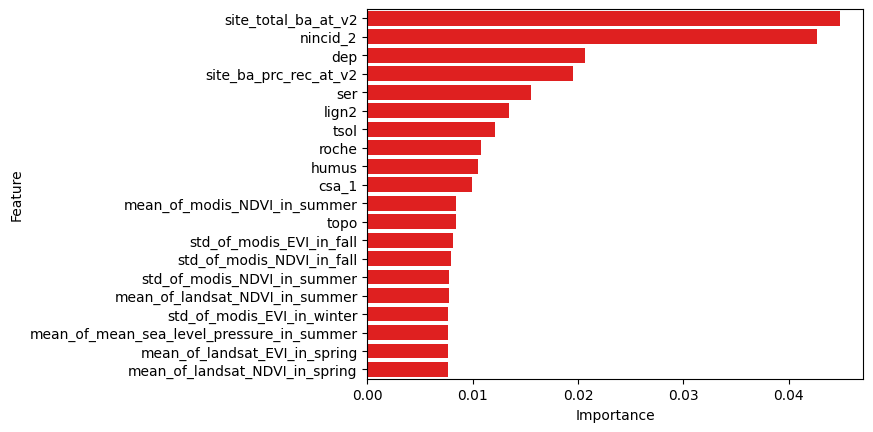

In [244]:
import seaborn as sns

# Plot the variable importance
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

df_featimp = pd.DataFrame(
    {
        "Feature": X_train.columns[indices],
        "Importance": importances[indices],
    }
)

# For features matching the string in vars_to_ohe, sum up their importances and set name to vars_to_ohe
rows_to_drop = []
rows_to_append = []
for var in vars_to_ohe:
    feat_sum = 0
    for i in range(len(df_featimp)):
        if var in df_featimp.loc[i, "Feature"]:
            feat_sum = feat_sum + df_featimp.loc[i, "Importance"]
            rows_to_drop.append(i)
    rows_to_append.append({"Feature": var, "Importance": feat_sum})

df_featimp = df_featimp.drop(rows_to_drop)
df_featimp = pd.concat([df_featimp, pd.DataFrame(rows_to_append)], ignore_index=True)
df_featimp = df_featimp.sort_values(by="Importance", ascending=False)
top_20 = df_featimp.head(20)

display(top_20)

# Plot the variable importance
sns.barplot(x="Importance", y="Feature", data=top_20, color="r")

In [240]:
df_featimp.query("Feature == 'lat'")

,Feature,Importance
31,lat,0.006718


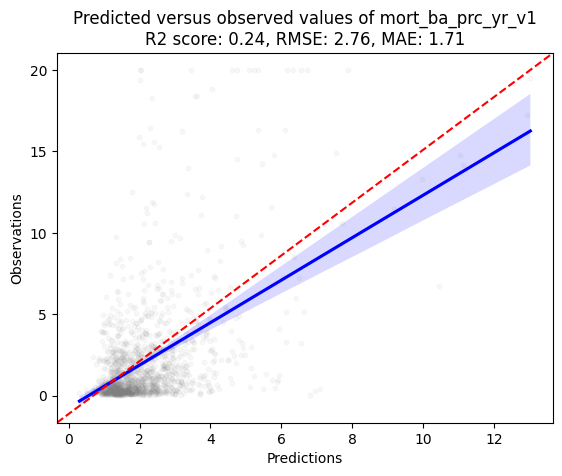

In [241]:
# Plot the predicted against true values
sns.regplot(
    x=y_pred,
    y=y_test,
    scatter_kws=dict(color="gray", s=10, alpha=0.05),
    line_kws=dict(color="blue"),
)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red")
plt.ylabel("Observations")
plt.xlabel("Predictions")
plt.title(
    f"Predicted versus observed values of {target}\nR2 score: {round(r2, 2)}, RMSE: {round(rmse, 2)}, MAE: {round(mae, 2)}"
)
plt.show()

In [242]:
for var in sorted(X_train_df.columns):
    print(var)

affroc
afpla
andain_0
andain_1
bord_0
bord_1
cai40
cailloux
campagne_1
campagne_2
cover_change_Clearcut
cover_change_Decreased Tree Cover
cover_change_Increased Tree Cover
cover_change_No Change
csa_1_1
csa_1_2
csa_1_3
csa_1_5
csa_2_1
csa_2_2
csa_2_3
csa_2_5
csa_2_7
dc_1
dc_2
dep_01
dep_02
dep_03
dep_04
dep_05
dep_06
dep_07
dep_08
dep_09
dep_1
dep_10
dep_11
dep_12
dep_13
dep_14
dep_15
dep_16
dep_17
dep_18
dep_19
dep_2
dep_21
dep_22
dep_23
dep_24
dep_25
dep_26
dep_27
dep_28
dep_29
dep_2A
dep_2B
dep_3
dep_30
dep_31
dep_32
dep_33
dep_34
dep_35
dep_36
dep_37
dep_38
dep_39
dep_4
dep_40
dep_41
dep_42
dep_43
dep_44
dep_45
dep_46
dep_47
dep_48
dep_49
dep_5
dep_50
dep_51
dep_52
dep_53
dep_54
dep_55
dep_56
dep_57
dep_58
dep_59
dep_6
dep_60
dep_61
dep_62
dep_63
dep_64
dep_65
dep_66
dep_67
dep_68
dep_69
dep_7
dep_70
dep_71
dep_72
dep_73
dep_74
dep_76
dep_77
dep_78
dep_79
dep_8
dep_80
dep_81
dep_82
dep_83
dep_84
dep_85
dep_86
dep_87
dep_88
dep_89
dep_9
dep_90
dep_91
dep_94
dep_95
gest
gre_A
gre_B
g